# Object Detection with SSD
### Here we demostrate detection on example images using SSD with PyTorch

In [77]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import numpy as np
import cv2
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

from ssd import build_ssd


%matplotlib inline
from matplotlib import pyplot as plt
from data import VOC_CLASSES as labels
import json
from tqdm import tqdm
import matplotlib.patches as patches

## Build SSD300 in Test Phase
1. Build the architecture, specifyingsize of the input image (300),
    and number of object classes to score (21 for VOC dataset)
2. Next we load pretrained weights on the VOC0712 trainval dataset  

In [2]:
net = build_ssd('test', 300, 21)    # initialize SSD
net.load_weights('../weights/ssd300_mAP_77.43_v2.pth')

Loading weights into state dict...
Finished!


## Load Image 
### Here we just load a sample image from the VOC07 dataset 

In [3]:
# image = cv2.imread('../data/example.jpg', cv2.IMREAD_COLOR)  # uncomment if dataset not downloaded
image = cv2.imread('../../bali26samples/aroid3.jpg', cv2.IMREAD_COLOR)  # uncomment if dataset not downloaded

# from data import VOCDetection, VOC_ROOT, VOCAnnotationTransform
# here we specify year (07 or 12) and dataset ('test', 'val', 'train') 
# testset = VOCDetection(VOC_ROOT, [('2007', 'val')], None, VOCAnnotationTransform())
# img_id = 60
# image = testset.pull_image(img_id)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# View the sampled input image before transform
plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.show()

NameError: name 'plt' is not defined

## Pre-process the input.  
#### Using the torchvision package, we can create a Compose of multiple built-in transorm ops to apply 
For SSD, at test time we use a custom BaseTransform callable to
resize our image to 300x300, subtract the dataset's mean rgb values, 
and swap the color channels for input to SSD300.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


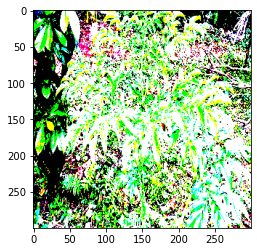

In [28]:
x = cv2.resize(image, (300, 300)).astype(np.float32)
x -= (104.0, 117.0, 123.0)
x = x.astype(np.float32)
x = x[:, :, ::-1].copy()
plt.imshow(x)
x = torch.from_numpy(x).permute(2, 0, 1)

## SSD Forward Pass
### Now just wrap the image in a Variable so it is recognized by PyTorch autograd

In [29]:
xx = Variable(x.unsqueeze(0))     # wrap tensor in Variable
if torch.cuda.is_available():
    xx = xx.cuda()
y = net(xx)

## Parse the Detections and View Results
Filter outputs with confidence scores lower than a threshold 
Here we choose 60% 

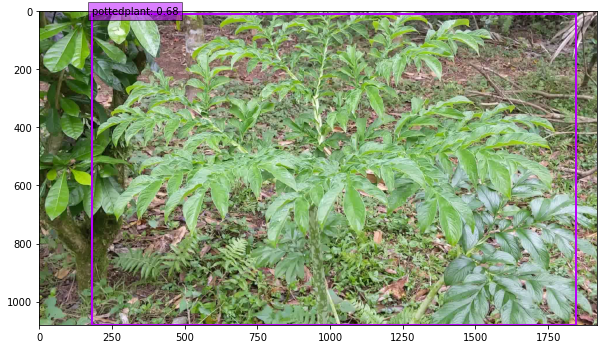

In [30]:
top_k=10

plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()

detections = y.data
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= 0.6:
        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1

## Script

In [103]:
def load_image(path):
    image = cv2.imread(path, cv2.IMREAD_COLOR)  # uncomment if dataset not downloaded

    # from data import VOCDetection, VOC_ROOT, VOCAnnotationTransform
    # here we specify year (07 or 12) and dataset ('test', 'val', 'train') 
    # testset = VOCDetection(VOC_ROOT, [('2007', 'val')], None, VOCAnnotationTransform())
    # img_id = 60
    # image = testset.pull_image(img_id)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # View the sampled input image before transform
#     plt.figure(figsize=(10,10))
#     plt.imshow(rgb_image)
#     plt.show()
    return image, rgb_image

def preprocess_input(image):
    x = cv2.resize(image, (300, 300)).astype(np.float32)
    x -= (104.0, 117.0, 123.0)
    x = x.astype(np.float32)
    x = x[:, :, ::-1].copy()
#     plt.imshow(x)
    x = torch.from_numpy(x).permute(2, 0, 1)
    return x

def detect(x, rgb_image, save_path):
#     global data_label
#     if name not in data_label:
#         data_label[name] = dict()
#     print (data_label)
    xx = Variable(x.unsqueeze(0))     # wrap tensor in Variable
    if torch.cuda.is_available():
        xx = xx.cuda()
    y = net(xx)
    
    top_k=10

    fig1 = plt.figure(figsize=(10,10))
    ax1 = fig1.add_subplot(111, aspect='equal')

    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
#     plt.imshow(rgb_image)  # plot the image for matplotlib
#     plt.title(name)
#     currentAxis = plt.gca()

    detections = y.data
    # scale each detection back up to the image
    scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
    for i in range(detections.size(1)):
        j = 0
        while detections[0,i,j,0] >= 0.6:
            score = detections[0,i,j,0]
            label_name = labels[i-1]
            display_txt = '%s: %.2f'%(label_name, score)
            pt = (detections[0,i,j,1:]*scale).cpu().numpy()
            coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
#             print (name, label_name, coords)
#             if label_name not in data_label[name]:
#                 data_label[name][label_name] = []
#             print (data_label[name])
#             data_label[name][label_name].append(pt)
#             print(data_label[name][label_name])
            color = colors[i]
            ax1.add_patch(patches.Rectangle(*coords, fill=False, edgecolor = color, linewidth=2))
            ax1.text(pt[0], pt[1], display_txt, bbox= {'facecolor':color, 'alpha':0.5})
#             currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
#             currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
            j+=1
    plt.imshow(rgb_image)
    plt.close(fig1)
    fig1.savefig(save_path)

In [96]:
def detection(path, save_path):
#     try:
    image, rgb_image = load_image(path)
    x = preprocess_input(image)
    detect(x, rgb_image, save_path)
#     except Exception as e:
#         print ('Error: ', path)
#         print (e)

In [97]:
output_folder = os.path.abspath("../../data/training/")
with open(os.path.join(output_folder, 'TRAIN_images.json'), 'r') as j:
    images = json.load(j)

In [106]:
output_folder_new = os.path.join(output_folder, 'images')
for image in tqdm(images):
    save_path = os.path.join(output_folder_new, '_'.join(image.split("/")[-2:]))
    img = detection(image, save_path)

100%|██████████| 19295/19295 [1:57:05<00:00,  2.75it/s]  


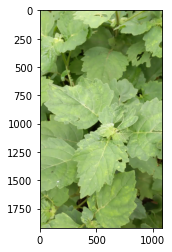

In [38]:
plt.imshow(img)

In [7]:
import os
import pickle
path = "../../data/bali-26/"
folders = os.listdir(path)

In [8]:
done = ['nilam', 'guava', 'sawo', 'taro', 'bamboo', 'coffeearabica', 'lychee', 'aroid']

In [10]:
for class_name in folders:
    print ("Class - ", class_name)
    if class_name in done:
        print ("Continued")
        continue
        
    data_label = dict()    
    file_path = path + class_name + "/"
    files = os.listdir(file_path)
    
    for image in files:
        detection(file_path, image, data_label)
    
    data_label_file_name = file_path + "{}_labels.pk".format(class_name)
    with open(data_label_file_name, "wb") as f:
        pickle.dump(data_label, f)
    
    print ("Detected_labels - ", len(data_label))

Class -  nilam
Continued
Class -  guava
Continued
Class -  sawo
Continued
Class -  taro
Continued
Class -  bamboo
Continued
Class -  coffeearabica
Continued
Class -  lychee
Continued
Class -  aroid
Continued
Class -  cinnamon
Error:  ../../data/bali-26/cinnamon/cinnamon_labels.pk
Detected_labels -  1360
Class -  mango
Error:  ../../data/bali-26/mango/mango_labels.pk
Detected_labels -  1492
Class -  papaya
Error:  ../../data/bali-26/papaya/papaya_labels.pk
Detected_labels -  1828
Class -  dragonfruit
Error:  ../../data/bali-26/dragonfruit/dragonfruit_labels.pk
Detected_labels -  2343
Class -  vanilla
Error:  ../../data/bali-26/vanilla/vanilla_labels.pk
Detected_labels -  2174
Class -  jackfruit
Error:  ../../data/bali-26/jackfruit/jackfruit_labels.pk
Detected_labels -  2967
Class -  frangipani
Error:  ../../data/bali-26/frangipani/frangipani_labels.pk
Detected_labels -  1741
Class -  sugarpalm
Error:  ../../data/bali-26/sugarpalm/sugarpalm_labels.pk
Detected_labels -  1396
Class -  whit

In [25]:
import pickle
path = "../../data/bali-26/banana/"
folders = os.listdir(path)
class_name = "banana"
data_label_file_name = path + "{}_labels.pk".format(class_name)

In [26]:
folders = sorted(folders)

In [27]:
data_label_file_name

'../../data/bali-26/banana/banana_labels.pk'

In [28]:
if os.path.getsize(data_label_file_name) > 0:   
    print ("yes")

yes


In [29]:
with open(data_label_file_name, "rb") as f:
    test = pickle.load(f)

In [33]:
test['0174.jpg']

{'pottedplant': [array([ 183.20967,   23.42064, 1694.1985 , 1040.7098 ], dtype=float32),
  array([1.5074287e+03, 1.1912227e+00, 1.8985245e+03, 5.5512964e+02],
        dtype=float32)]}

In [16]:
# with open("../../data_labels.pk", "wb") as f:
#     pickle.dump(data_label, f)

# with open("../../data_labels.pk", "rb") as f:
#     test = pickle.load(f)

In [12]:
# for image in bali_samples:
#     detection("../../bali26samples/",image)
# print ("MIXED PLANTS")
# for image in bali_mixed_samples:
#     detection("../../balimixedplants/",image)